In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
data = np.loadtxt(r'./data/withBForward3.txt')
df = pd.DataFrame(data)
df.columns = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw',
    'SpeedEast', 'SpeedNorth', 'SpeedSky', 'lat', 'lng', 'height',
    'GPSlat', 'GPSlng', 'GPSheight', 'GPSspeed', 'GPSheading',
    'dvl1', 'dvl2', 'dvl3', 'dvl4', 'RTKlat', 'RTKlng', 'useless',
    'INSStatus', 'GPSStatus', 'useless2', 'useless3', 'RTKStatus']

df2 = df.drop(['dvl1', 'dvl2', 'dvl3', 'dvl4', 'INSStatus', 'GPSStatus', 'useless2', 'RTKStatus'], axis=1)
df2.head()

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,height,GPSlat,GPSlng,GPSheight,GPSspeed,GPSheading,RTKlat,RTKlng,useless,useless3
0,0.103259,-0.064724,-9.807859,0.022537,-0.025295,0.044811,-0.033,0.6317,96.0864,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
1,0.078615,-0.041932,-9.807854,0.006565,0.001663,-0.026666,-0.033,0.6317,96.0864,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
2,0.103286,-0.041934,-9.783177,-0.010336,0.005162,-0.105716,-0.033,0.6317,96.0864,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
3,0.128002,0.003628,-9.807908,-0.021585,0.018490,-0.149164,-0.033,0.6317,96.0864,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
4,0.127989,0.003614,-9.807908,-0.026712,0.025154,-0.137345,-0.033,0.6317,96.0809,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0


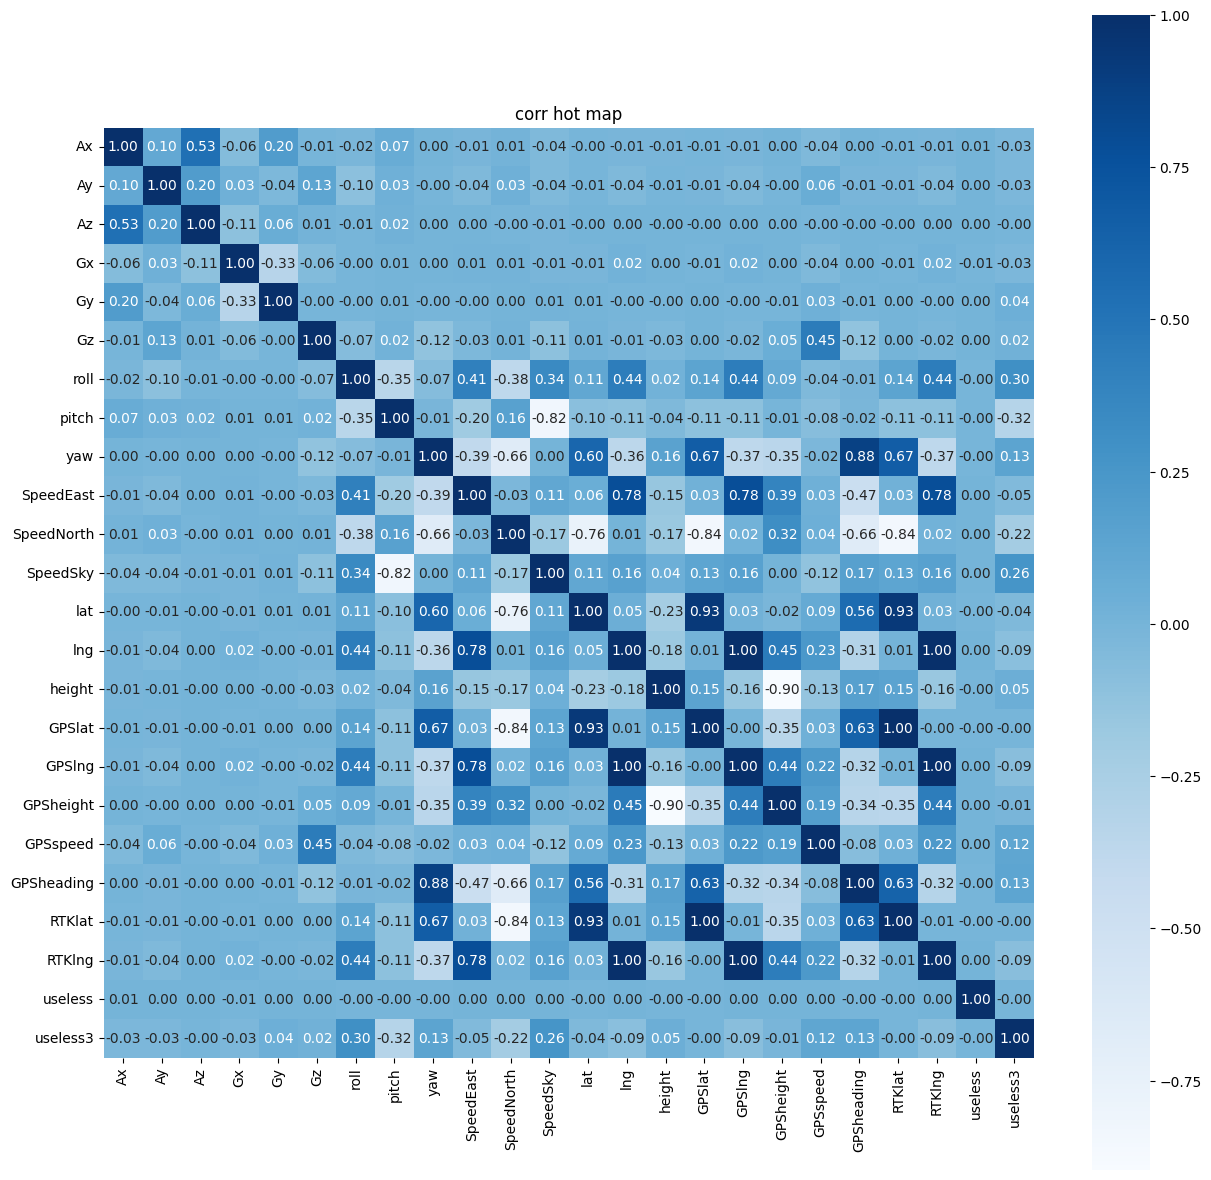

In [3]:
# df.corr()
fig, ax = plt.subplots(figsize=(15, 15),facecolor='w')
# 指定颜色带的色系
sns.heatmap(df2.corr(),annot=True, vmax=1, square=True, cmap="Blues", fmt='.2f')
plt.title('corr hot map')
plt.show()

array([[<AxesSubplot:title={'center':'Ax'}>,
        <AxesSubplot:title={'center':'Ay'}>,
        <AxesSubplot:title={'center':'Az'}>,
        <AxesSubplot:title={'center':'Gx'}>,
        <AxesSubplot:title={'center':'Gy'}>],
       [<AxesSubplot:title={'center':'Gz'}>,
        <AxesSubplot:title={'center':'roll'}>,
        <AxesSubplot:title={'center':'pitch'}>,
        <AxesSubplot:title={'center':'yaw'}>,
        <AxesSubplot:title={'center':'SpeedEast'}>],
       [<AxesSubplot:title={'center':'SpeedNorth'}>,
        <AxesSubplot:title={'center':'SpeedSky'}>,
        <AxesSubplot:title={'center':'lat'}>,
        <AxesSubplot:title={'center':'lng'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'GPSlat'}>,
        <AxesSubplot:title={'center':'GPSlng'}>,
        <AxesSubplot:title={'center':'GPSheight'}>,
        <AxesSubplot:title={'center':'GPSspeed'}>,
        <AxesSubplot:title={'center':'GPSheading'}>],
       [<AxesSubplot:title={'cente

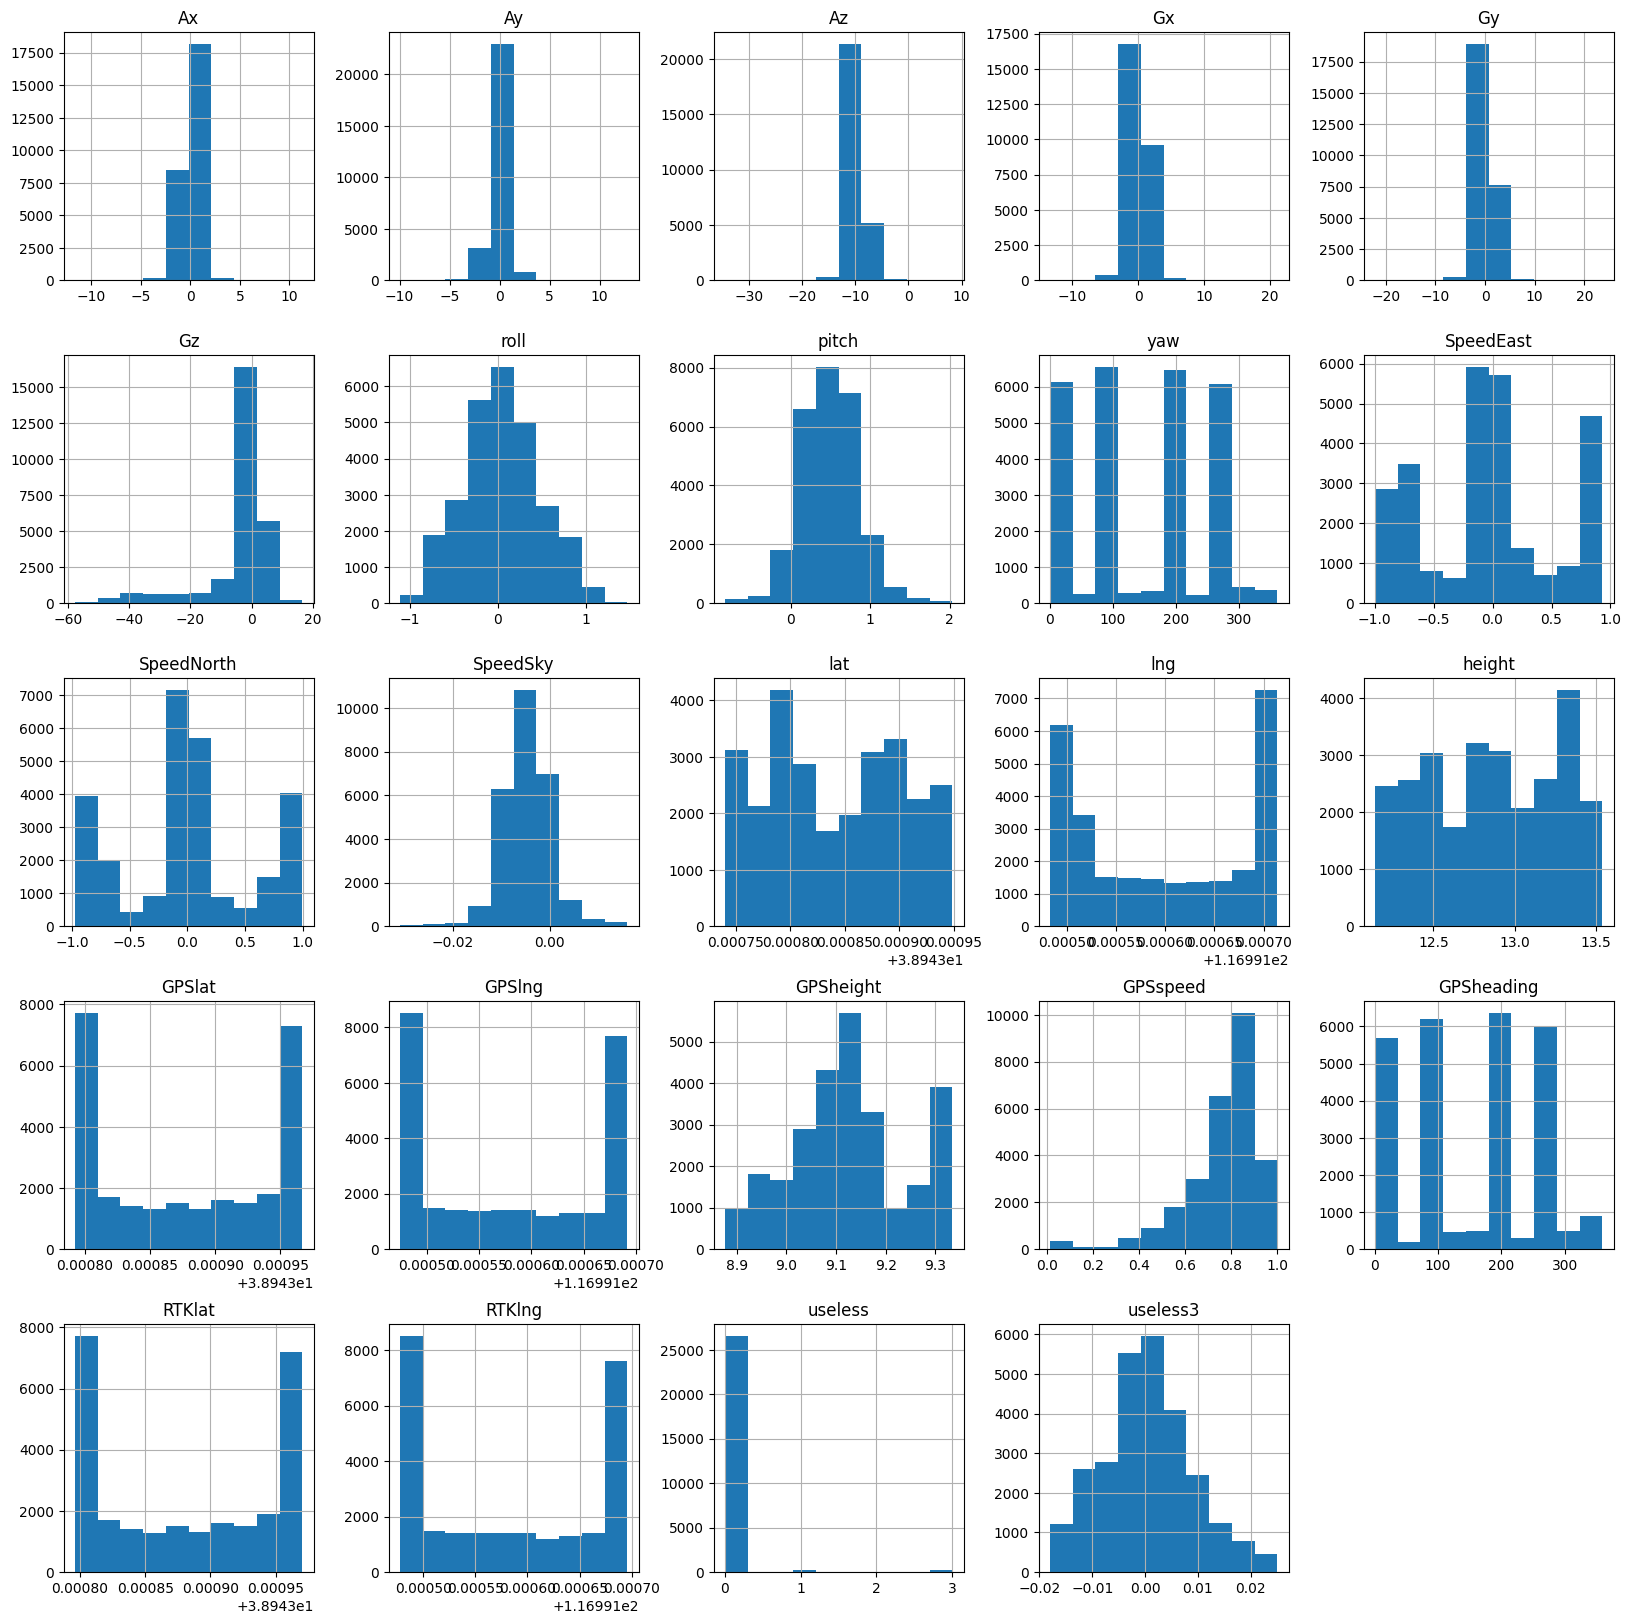

In [137]:
df2.hist(figsize=(20, 20))

# <font color='orange'> 姿态解算过程 </font>

## 单步建模


建模总体思路：将上一个时间片的特征值作为下一个时间片的输入，将当前时间片的偏航、俯仰、翻滚征作为label <br>
可依赖特征：当前时刻的（Ax, Ay, Az, Gx, Gy, Gz）上一时刻的（roll, pitch, yaw）<br>
label: 当前时刻的（roll, pitch, yaw）<br>
1）特征工程：特征的归一化，剔除异常值 <br>
2）模型选择：xgb 

In [50]:
df_cal_attitude_single_step = deepcopy(df2)
df_cal_attitude_single_step.head(1)

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,height,GPSlat,GPSlng,GPSheight,GPSspeed,GPSheading,RTKlat,RTKlng,useless,useless3
0,0.103259,-0.064724,-9.807859,0.022537,-0.025295,0.044811,-0.033,0.6317,96.0864,0.001,...,12.141,38.94381,116.991484,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0


In [51]:
# 构造label
df_cal_attitude_single_step['label_roll'] = df_cal_attitude_single_step['roll'].shift(-1)
df_cal_attitude_single_step['label_yaw'] = df_cal_attitude_single_step['yaw'].shift(-1)
df_cal_attitude_single_step['label_pitch'] = df_cal_attitude_single_step['pitch'].shift(-1)
df_cal_attitude_single_step = df_cal_attitude_single_step.dropna(how='any')
df_cal_attitude_single_step.tail(5)

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,GPSheight,GPSspeed,GPSheading,RTKlat,RTKlng,useless,useless3,label_roll,label_yaw,label_pitch
27126,0.004660,-0.064632,-9.783102,0.009372,-0.021778,-0.077314,0.3461,0.2087,93.0212,-0.001,...,8.996,0.02,113.0328,38.943813,116.991488,0.0,0.001,0.3461,93.0212,0.2087
27127,0.004630,-0.087426,-9.807784,0.008588,-0.013478,-0.077080,0.3461,0.2087,93.0212,-0.001,...,8.996,0.02,113.0328,38.943813,116.991488,0.0,0.001,0.3461,93.0157,0.2087
27128,0.004649,-0.064650,-9.783102,0.007534,-0.021262,-0.059283,0.3461,0.2087,93.0157,-0.001,...,8.996,0.02,113.0328,38.943813,116.991488,0.0,0.001,0.3461,93.0157,0.2087
27129,0.004646,-0.064657,-9.807795,0.020202,-0.028363,-0.021128,0.3461,0.2087,93.0157,-0.001,...,8.996,0.02,113.0328,38.943813,116.991488,0.0,0.001,0.3461,93.0157,0.2087
27130,-0.020029,-0.064661,-9.783085,0.010213,-0.016225,0.026960,0.3461,0.2087,93.0157,-0.001,...,8.996,0.02,113.0328,38.943813,116.991488,0.0,0.001,0.3461,93.0157,0.2087


In [52]:
# 特征工程

In [55]:
# xgboost初试
X = df_cal_attitude_single_step.iloc[:-1000].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']]
y = df_cal_attitude_single_step.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 6.006344385358684


In [54]:
predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
k = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), predicted_df.reset_index(drop=True)], axis=1)
k

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,label_roll,label_pitch,label_yaw,pred_roll,pred_pitch,pred_yaw
0,0.097748,0.231090,-10.079581,-0.667820,0.724969,-32.625519,-0.3735,1.3678,337.6318,-0.3955,1.3733,337.3022,-0.388818,1.381356,336.516205
1,0.445253,0.096369,-9.832774,0.825020,-0.596393,-37.856541,-0.0385,-0.1923,268.1763,-0.0275,-0.1978,267.7972,-0.030544,-0.195349,267.663025
2,0.408801,0.212653,-7.240083,1.171135,0.538212,-1.035092,0.4010,0.4889,3.9111,0.4120,0.4834,3.9056,0.410101,0.481453,4.010036
3,0.941082,-0.016857,-9.215784,1.441540,0.880350,-0.769175,0.6427,0.2087,275.5042,0.6427,0.1978,275.4987,0.644228,0.200369,275.507141
4,0.173431,-0.867143,-9.288957,-0.516333,0.106971,-2.118511,0.0385,-0.0989,183.5815,0.0330,-0.0989,183.5596,0.035533,-0.097761,183.661972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222,-0.067106,0.668820,-9.338928,1.465218,-0.101297,-3.969550,0.7635,0.4175,5.4987,0.7690,0.4175,5.4602,0.769015,0.409990,5.425795
5223,0.619192,0.419021,-9.931815,0.196058,0.210749,-38.763786,-0.6317,1.3184,330.2985,-0.6372,1.3184,329.9194,-0.635587,1.326157,330.117981
5224,0.276318,-0.176939,-9.363434,0.054427,-0.106971,0.206779,-0.1923,0.4944,187.1631,-0.1978,0.4889,187.1686,-0.188681,0.495028,187.194244
5225,0.500353,-0.452634,-9.659767,0.159062,-0.074388,-3.585537,0.6537,0.4504,5.2185,0.6537,0.4504,5.1801,0.657469,0.447021,5.149099


In [60]:
X_true_test = df_cal_attitude_single_step.iloc[-1000:].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']].reset_index(drop=True)
X_true_test

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw
0,0.673945,0.599942,-8.524494,1.411661,0.653519,-0.210685,0.2582,0.6427,186.2622
1,0.400704,-0.402048,-10.919095,2.406212,-1.096165,0.749446,0.2747,0.6372,186.2677
2,-0.337759,1.148000,-9.635305,2.150663,-0.660688,1.659235,0.2911,0.6207,186.2787
3,0.523930,0.009167,-10.326729,1.642616,0.845261,2.105796,0.3186,0.6317,186.2952
4,0.374968,-0.035779,-9.585806,2.151350,-0.265849,2.528730,0.3351,0.6372,186.3226
...,...,...,...,...,...,...,...,...,...
995,0.004660,-0.064632,-9.783102,0.009372,-0.021778,-0.077314,0.3461,0.2087,93.0212
996,0.004630,-0.087426,-9.807784,0.008588,-0.013478,-0.077080,0.3461,0.2087,93.0212
997,0.004649,-0.064650,-9.783102,0.007534,-0.021262,-0.059283,0.3461,0.2087,93.0157
998,0.004646,-0.064657,-9.807795,0.020202,-0.028363,-0.021128,0.3461,0.2087,93.0157


In [63]:
X_true_test.iloc[0:1, :]

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw
0,0.673945,0.599942,-8.524494,1.411661,0.653519,-0.210685,0.2582,0.6427,186.2622


In [85]:
# 对真实Test集进行连续预测，并得到连续变化的姿态角
X_true_test = df_cal_attitude_single_step.iloc[-1000:].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']].reset_index(drop=True)
y_true_test = df_cal_attitude_single_step.iloc[-1000:][['label_roll', 'label_pitch', 'label_yaw']]

pred_result = None
predicted_df = None
# 循环遍历X_true_test，模型的预估值作为下一时刻模型的输入roll, pitch, yaw
for index in range(X_true_test.shape[0]):
    if index == 0:
        X_true_test_sample = X_true_test.iloc[index:index+1]
        pred_sample = model.predict(X_true_test_sample)
        predicted_df = pd.DataFrame(pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
        pred_result = predicted_df
    else:
        X_true_test_sample = X_true_test.loc[index:index, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']]
        X_true_test_sample = pd.concat([X_true_test_sample.reset_index(drop=True),
                                        predicted_df.reset_index(drop=True)], axis=1)
        pred_sample = model.predict(X_true_test_sample)
        predicted_df = pd.DataFrame(pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
        pred_result = pd.concat([pred_result, predicted_df], axis=0)
        
pred_result.head()

,pred_roll,pred_pitch,pred_yaw
0,0.273724,0.640474,186.193970
0,0.289064,0.634698,186.176437
0,0.305164,0.629442,186.155533
0,0.317193,0.633930,186.132156
0,0.334975,0.626280,186.142365


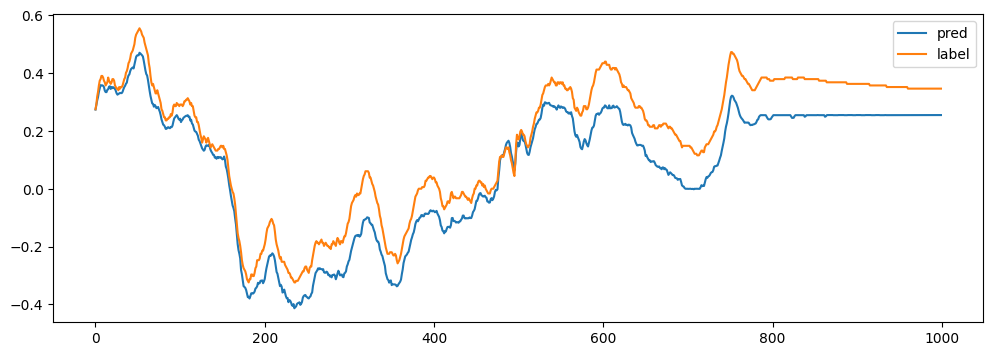

In [91]:
# 绘制姿态角曲线
fig = plt.figure(figsize=(12, 4))
plt.plot(range(pred_result.shape[0]), pred_result['pred_roll'], label='pred')
plt.plot(range(y_true_test.shape[0]), y_true_test['label_roll'], label='label')
plt.legend()
plt.show()



In [93]:
## 该结果表明直接使用模型进行姿态的连续解算在理论上是可行的。

## 时序数据建模

建模总体思路：将前N个时间片的特征值作为下一个时间片的输入，将当前时间片的偏航、俯仰、翻滚征作为label <br>
可依赖特征：前N个时刻的（Ax, Ay, Az, Gx, Gy, Gz），前N个时刻的（roll, pitch, yaw）<br>
label: 当前时刻的（roll, pitch, yaw）<br>
1）特征工程：特征的归一化，剔除异常值 <br>
2）模型选择：xgb

附：使用时序建模的优势 <br>
时序信息：历史数据能捕捉时间序列的趋势和周期性，提供更丰富的上下文信息，帮助模型更好地理解动态变化。<br>
噪声平滑：历史数据可以帮助平滑偶然的噪声，减少单次测量的误差对预测的影响。 （有利于避免误差累积）<br>
模型鲁棒性和泛化性：利用多个时间点的数据，模型可以对不同情况进行学习，增强对变化环境的适应能力。<br>

In [10]:
df_cal_attitude_multi_step = deepcopy(df2)
df_cal_attitude_multi_step.head(1)
N = 9  # 历史窗口值 

# label和时序特征的构造
# label
df_cal_attitude_multi_step['label_roll'] = df_cal_attitude_multi_step['roll'].shift(-1)
df_cal_attitude_multi_step['label_yaw'] = df_cal_attitude_multi_step['yaw'].shift(-1)
df_cal_attitude_multi_step['label_pitch'] = df_cal_attitude_multi_step['pitch'].shift(-1)
# features
# fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']
fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
for fea in fea_names:
    for n in range(1, N+1):
        df_cal_attitude_multi_step[f'{fea}_last_{n}'] = df_cal_attitude_multi_step[fea].shift(n)
df_cal_attitude_multi_step = df_cal_attitude_multi_step.dropna(how='any')
df_cal_attitude_multi_step

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,Gy_last_9,Gz_last_1,Gz_last_2,Gz_last_3,Gz_last_4,Gz_last_5,Gz_last_6,Gz_last_7,Gz_last_8,Gz_last_9
9,0.103306,-0.019131,-9.783188,0.060027,-0.032087,0.079858,-0.0275,0.6317,96.0809,0.001,...,-0.025295,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716,-0.026666,0.044811
10,0.103320,-0.019110,-9.807881,0.037618,-0.028437,0.050120,-0.0275,0.6317,96.0864,0.001,...,0.001663,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716,-0.026666
11,0.078626,-0.041886,-9.807854,0.018852,-0.017734,0.004544,-0.0275,0.6317,96.0864,0.001,...,0.005162,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716
12,0.078629,-0.041887,-9.807854,0.003355,0.000916,-0.048165,-0.0275,0.6317,96.0864,0.001,...,0.018490,0.004544,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164
13,0.078621,-0.041895,-9.783161,-0.010137,0.006207,-0.071032,-0.0275,0.6317,96.0864,0.001,...,0.025154,-0.048165,0.004544,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27126,0.004660,-0.064632,-9.783102,0.009372,-0.021778,-0.077314,0.3461,0.2087,93.0212,-0.001,...,-0.026994,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971,-0.037209,-0.086093
27127,0.004630,-0.087426,-9.807784,0.008588,-0.013478,-0.077080,0.3461,0.2087,93.0212,-0.001,...,-0.036327,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971,-0.037209
27128,0.004649,-0.064650,-9.783102,0.007534,-0.021262,-0.059283,0.3461,0.2087,93.0157,-0.001,...,-0.044768,-0.077080,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971
27129,0.004646,-0.064657,-9.807795,0.020202,-0.028363,-0.021128,0.3461,0.2087,93.0157,-0.001,...,-0.053239,-0.059283,-0.077080,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774


In [15]:
# xgboost初试
X = df_cal_attitude_multi_step.iloc[:-1000].drop(['SpeedEast', 'SpeedNorth', 'SpeedSky', 'lat', 'lng', 'height', 'GPSlat',
                                                   'GPSlng', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                                   'useless', 'useless3', 'label_roll', 'label_pitch', 'label_yaw'], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5',  'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw']
X = X.loc[:, feature_list]
y = df_cal_attitude_multi_step.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
k = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), predicted_df.reset_index(drop=True)], axis=1)
k

Mean Squared Error: 0.19649619770078564


,Ax,Ay,Az,Gx,Gy,Gz,Ax_last_1,Ax_last_2,Ax_last_3,Ax_last_4,...,Gz_last_9,roll,pitch,yaw,label_roll,label_pitch,label_yaw,pred_roll,pred_pitch,pred_yaw
0,0.101216,0.049585,-10.005463,0.215704,-0.026508,-0.503111,0.151587,-0.613767,0.696208,0.301697,...,1.729071,-0.4449,0.2692,98.3221,-0.4395,0.2911,98.3112,-0.440002,0.269418,98.236763
1,0.648436,0.100839,-11.215822,-0.895429,2.455620,4.498419,-0.091451,0.179764,0.301379,-0.756933,...,5.834014,0.1868,0.4724,9.4922,0.1813,0.4889,9.5361,0.182425,0.500118,9.703035
2,0.513269,-0.822761,-8.918750,1.498797,-0.826815,-28.109575,0.613068,0.242355,0.785132,-0.473343,...,-27.701238,0.4999,0.6152,23.6316,0.5164,0.6207,23.3459,0.504603,0.616308,22.769579
3,0.472466,0.302241,-8.252595,0.802126,-1.161448,1.379195,-0.070168,-0.145247,0.570929,-0.788015,...,0.437300,-0.2692,0.3571,185.1086,-0.2637,0.3461,185.1251,-0.260388,0.350147,185.058411
4,0.422032,-0.293699,-9.610409,-0.682838,0.515041,1.223699,0.496430,-0.022076,0.002754,-0.023006,...,0.065814,-0.1483,0.5878,185.8118,-0.1538,0.5878,185.8228,-0.160238,0.590700,185.882965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.538787,0.516037,-8.277424,-1.468310,-0.492821,-18.724046,-0.449509,1.772707,0.367055,-1.060708,...,-15.175401,0.3845,0.6372,290.0995,0.3790,0.6262,289.9127,0.374280,0.629453,289.949463
5221,0.175827,-0.201241,-11.808020,1.083526,0.925659,2.697483,-0.218665,1.188222,-0.614698,-0.416388,...,4.729155,0.1593,-0.1318,182.9169,0.1703,-0.1318,182.9443,0.171573,-0.118098,183.133041
5222,-0.202126,-0.639048,-10.449340,0.497781,-1.777299,-36.710509,0.240154,-0.155003,1.104862,-0.324599,...,-38.763786,-0.6537,1.2909,326.9696,-0.6592,1.2854,326.6016,-0.657795,1.285979,326.216431
5223,-0.141794,0.847972,-9.388355,-0.648094,0.039398,0.356606,0.276318,-0.168239,0.104635,-0.215415,...,1.908900,-0.1978,0.4889,187.1686,-0.2032,0.4889,187.1686,-0.198992,0.497738,187.184784


In [26]:
X_true_test = df_cal_attitude_multi_step.iloc[-1000:-500].drop(['lat', 'lng', 'height', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                            'useless', 'useless3', 'label_roll', 'label_pitch', 'label_yaw'], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw']
X_true_test = X_true_test.loc[:, feature_list].reset_index(drop=True)
y_true_test = df_cal_attitude_multi_step.iloc[-1000:-500][['label_roll', 'label_pitch', 'label_yaw']].reset_index(drop=True)

array([[2.7322027e-01, 6.3840818e-01, 1.8625713e+02],
       [2.9249221e-01, 6.3094121e-01, 1.8627589e+02],
       [3.0952519e-01, 6.2111586e-01, 1.8629294e+02],
       ...,
       [1.5365335e-01, 4.6196339e-01, 1.3664459e+02],
       [1.9244091e-01, 4.1573468e-01, 1.3709866e+02],
       [1.7577523e-01, 4.3634233e-01, 1.3687532e+02]], dtype=float32)

In [27]:
multi_step_pred_result = None  # 测试集结果
multi_step_pred_sample = None  # 临时变量，保存单次预估结果
feature_list_part = [
    'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
    'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
    'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
    'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
    'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
    'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
    'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9']
# 循环遍历X_true_test，模型的预估值作为下一时刻模型的输入roll, pitch, yaw
for index in range(X_true_test.shape[0]):
    if index == 0:
        X_true_test_sample = X_true_test.iloc[index:index+1]
        X_true_test_sample = X_true_test_sample.loc[:, feature_list]
        y_pred_sample = model.predict(X_true_test_sample)
        multi_step_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
        multi_step_pred_result = multi_step_pred_sample
    else:
        X_true_test_sample = X_true_test.loc[index:index, feature_list_part]
        X_true_test_sample = pd.concat([X_true_test_sample.reset_index(drop=True),
                                        multi_step_pred_sample.reset_index(drop=True)], axis=1)
        y_pred_sample = model.predict(X_true_test_sample)
        multi_step_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
        multi_step_pred_result = pd.concat([multi_step_pred_result, multi_step_pred_sample], axis=0)
        
multi_step_pred_result.head()

,pred_roll,pred_pitch,pred_yaw
0,0.273220,0.638408,186.257126
0,0.292492,0.630941,186.275894
0,0.309525,0.630221,186.292938
0,0.323855,0.629047,186.266479
0,0.345255,0.625869,186.246246


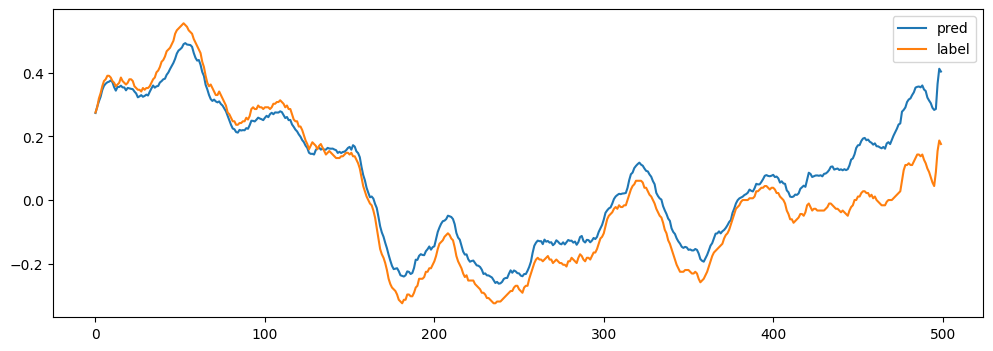

In [28]:
# 绘制姿态角曲线
fig = plt.figure(figsize=(12, 4))
plt.plot(range(multi_step_pred_result.shape[0]), multi_step_pred_result['pred_roll'], label='pred')
plt.plot(range(y_true_test.shape[0]), y_true_test['label_roll'], label='label')
plt.legend()
plt.show()

In [ ]:
## 该结果表明使用时序数据可以提升姿态的解算的准确性。

## LSTM

In [36]:
# 使用深度学习模型进行建模

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设 df_cal_attitude_multi_step 已经构造完毕
df_cal_attitude_lstm = deepcopy(df2)
df_cal_attitude_lstm['label_roll'] = df_cal_attitude_lstm['roll'].shift(-1)
df_cal_attitude_lstm['label_yaw'] = df_cal_attitude_lstm['yaw'].shift(-1)
df_cal_attitude_lstm['label_pitch'] = df_cal_attitude_lstm['pitch'].shift(-1)
df_cal_attitude_lstm = df_cal_attitude_lstm.dropna(how='any')

# 准备特征和标签
X = df_cal_attitude_lstm.iloc[:-1000].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']]
y = df_cal_attitude_lstm.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw']]

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

# 将数据转化为序列形式
N = 9  # 历史窗口值
X_seq = []
y_seq = []

for i in range(N, len(X_tensor)):
    X_seq.append(X_tensor[i-N:i])
    y_seq.append(y_tensor[i])

X_seq = torch.stack(X_seq)
y_seq = torch.stack(y_seq)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# 初始化模型
input_size = X_tensor.shape[1]
hidden_size = 256
output_size = 3  # roll, pitch, yaw

model = LSTMModel(input_size, hidden_size, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 反标准化
y_pred = scaler_y.inverse_transform(y_pred.numpy())
y_test = scaler_y.inverse_transform(y_test.numpy())

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 显示预测结果
predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
print(predicted_df.head())

Epoch [10/1000], Loss: 0.5718
Epoch [20/1000], Loss: 0.1034
Epoch [30/1000], Loss: 0.0441
Epoch [40/1000], Loss: 0.0233
Epoch [50/1000], Loss: 0.0125
Epoch [60/1000], Loss: 0.0078
Epoch [70/1000], Loss: 0.0059
Epoch [80/1000], Loss: 0.0050
Epoch [90/1000], Loss: 0.0045
Epoch [100/1000], Loss: 0.0042
Epoch [110/1000], Loss: 0.0040
Epoch [120/1000], Loss: 0.0038
Epoch [130/1000], Loss: 0.0037
Epoch [140/1000], Loss: 0.0036
Epoch [150/1000], Loss: 0.0035
Epoch [160/1000], Loss: 0.0035
Epoch [170/1000], Loss: 0.0034
Epoch [180/1000], Loss: 0.0034
Epoch [190/1000], Loss: 0.0033
Epoch [200/1000], Loss: 0.0033
Epoch [210/1000], Loss: 0.0032
Epoch [220/1000], Loss: 0.0032
Epoch [230/1000], Loss: 0.0032
Epoch [240/1000], Loss: 0.0031
Epoch [250/1000], Loss: 0.0031
Epoch [260/1000], Loss: 0.0031
Epoch [270/1000], Loss: 0.0030
Epoch [280/1000], Loss: 0.0030
Epoch [290/1000], Loss: 0.0030
Epoch [300/1000], Loss: 0.0030
Epoch [310/1000], Loss: 0.0029
Epoch [320/1000], Loss: 0.0029
Epoch [330/1000],

In [47]:
# 对真实Test集进行连续预测，并得到连续变化的姿态角
X_true_test = df_cal_attitude_lstm.iloc[-1000:-500].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']]
y_true_test = df_cal_attitude_lstm.iloc[-1000:-500][['label_roll', 'label_pitch', 'label_yaw']]

lstm_test_result = None

X_true_test_scaled = scaler_X.fit_transform(X_true_test)
# y_scaled = scaler_y.fit_transform(y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_true_test_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

# 将数据转化为序列形式
N = 9  # 历史窗口值

# 进行预测
model.eval()
with torch.no_grad():
    for i in range(N, len(X_tensor)):
        X_seq = []
        X_seq.append(X_tensor[i-N:i])
        X_seq = torch.stack(X_seq)
        y_pred = model(X_seq)
        X_tensor[i, -3:] = y_pred.squeeze()
        y_pred = scaler_y.inverse_transform(y_pred.numpy())
        predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw'])
        lstm_test_result = pd.concat([lstm_test_result, predicted_df], axis=0)

lstm_test_result.head(5)

,pred_roll,pred_pitch,pred_yaw
0,0.705952,0.177756,205.499283
0,0.710518,0.203516,205.123428
0,0.705666,0.231671,204.760696
0,0.676916,0.241746,204.002396
0,0.677069,0.233035,203.518616


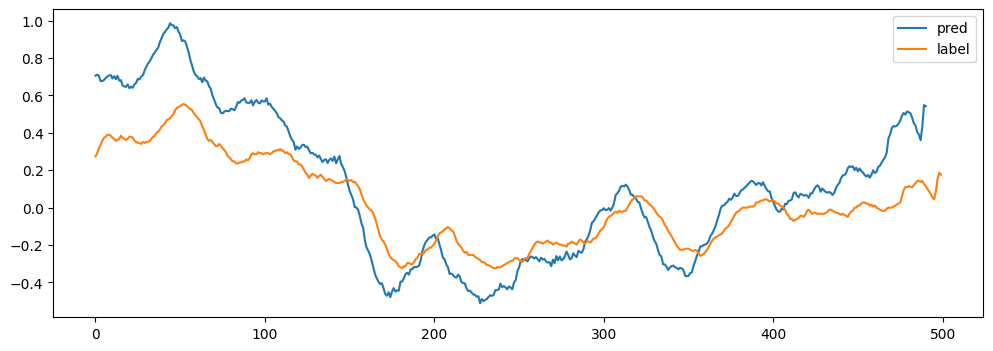

In [48]:
# 绘制姿态角曲线
fig = plt.figure(figsize=(12, 4))
plt.plot(range(lstm_test_result.shape[0]), lstm_test_result['pred_roll'], label='pred')
plt.plot(range(y_true_test.shape[0]), y_true_test['label_roll'], label='label')
plt.legend()
plt.show()

# 位移解算过程

## 时序数据建模

建模总体思路：将前N个时间片的特征值作为下一个时间片的输入，将当前时间片的经、纬度作为label <br>
可依赖特征：前N个时刻的（Ax, Ay, Az, Gx, Gy, Gz）初始状态的的（ 'roll', 'pitch', 'yaw', 'SpeedEast', 'SpeedNorth', 'SpeedSky'，'GPSlat', 'GPSlng' <br>
label: 当前时刻的（lat, lng）<br>
1）特征工程：特征的归一化，剔除异常值 <br>
2）模型选择：xgb

附：使用时序建模的优势 <br>
时序信息：历史数据能捕捉时间序列的趋势和周期性，提供更丰富的上下文信息，帮助模型更好地理解动态变化。<br>
噪声平滑：历史数据可以帮助平滑偶然的噪声，减少单次测量的误差对预测的影响。 （有利于避免误差累积）<br>
模型鲁棒性和泛化性：利用多个时间点的数据，模型可以对不同情况进行学习，增强对变化环境的适应能力。<br>

In [53]:
df_cal_displacement = deepcopy(df2)
N = 9  # 历史窗口值 

# label和时序特征的构造
# label
df_cal_displacement['label_roll'] = df_cal_displacement['roll'].shift(-1)
df_cal_displacement['label_pitch'] = df_cal_displacement['pitch'].shift(-1)
df_cal_displacement['label_yaw'] = df_cal_displacement['yaw'].shift(-1)
df_cal_displacement['label_GPSlat'] = df_cal_displacement['GPSlat'].shift(-1)
df_cal_displacement['label_GPSlng'] = df_cal_displacement['GPSlng'].shift(-1)
df_cal_displacement['label_SpeedEast'] = df_cal_displacement['SpeedEast'].shift(-1)
df_cal_displacement['label_SpeedNorth'] = df_cal_displacement['SpeedNorth'].shift(-1)
df_cal_displacement['label_SpeedSky'] = df_cal_displacement['SpeedSky'].shift(-1)

# features
# fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']
fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
for fea in fea_names:
    for n in range(1, N+1):
        df_cal_displacement[f'{fea}_last_{n}'] = df_cal_displacement[fea].shift(n)
df_cal_displacement = df_cal_displacement.dropna(how='any')
df_cal_displacement

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,Gy_last_9,Gz_last_1,Gz_last_2,Gz_last_3,Gz_last_4,Gz_last_5,Gz_last_6,Gz_last_7,Gz_last_8,Gz_last_9
9,0.103306,-0.019131,-9.783188,0.060027,-0.032087,0.079858,-0.0275,0.6317,96.0809,0.001,...,-0.025295,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716,-0.026666,0.044811
10,0.103320,-0.019110,-9.807881,0.037618,-0.028437,0.050120,-0.0275,0.6317,96.0864,0.001,...,0.001663,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716,-0.026666
11,0.078626,-0.041886,-9.807854,0.018852,-0.017734,0.004544,-0.0275,0.6317,96.0864,0.001,...,0.005162,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164,-0.105716
12,0.078629,-0.041887,-9.807854,0.003355,0.000916,-0.048165,-0.0275,0.6317,96.0864,0.001,...,0.018490,0.004544,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345,-0.149164
13,0.078621,-0.041895,-9.783161,-0.010137,0.006207,-0.071032,-0.0275,0.6317,96.0864,0.001,...,0.025154,-0.048165,0.004544,0.050120,0.079858,0.080391,0.054654,0.004933,-0.072969,-0.137345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27126,0.004660,-0.064632,-9.783102,0.009372,-0.021778,-0.077314,0.3461,0.2087,93.0212,-0.001,...,-0.026994,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971,-0.037209,-0.086093
27127,0.004630,-0.087426,-9.807784,0.008588,-0.013478,-0.077080,0.3461,0.2087,93.0212,-0.001,...,-0.036327,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971,-0.037209
27128,0.004649,-0.064650,-9.783102,0.007534,-0.021262,-0.059283,0.3461,0.2087,93.0157,-0.001,...,-0.044768,-0.077080,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774,0.006971
27129,0.004646,-0.064657,-9.807795,0.020202,-0.028363,-0.021128,0.3461,0.2087,93.0157,-0.001,...,-0.053239,-0.059283,-0.077080,-0.077314,-0.062700,-0.040526,-0.013110,0.011399,0.030564,0.032774


In [55]:
# xgboost初试
X = df_cal_displacement.iloc[:-1000].drop(['lat', 'lng', 'height', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                            'useless', 'useless3', 'label_roll', 'label_pitch','label_yaw', 'label_GPSlat',
                                            'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky',], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw', 'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']
X = X.loc[:, feature_list]
y = df_cal_displacement.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng',
                                       'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
k = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), predicted_df.reset_index(drop=True)], axis=1)
k

Mean Squared Error: 0.07646500915683527


,Ax,Ay,Az,Gx,Gy,Gz,Ax_last_1,Ax_last_2,Ax_last_3,Ax_last_4,...,label_SpeedNorth,label_SpeedSky,pred_roll,pred_pitch,pred_yaw,pred_GPSlat,pred_GPSlng,pred_SpeedEast,pred_SpeedNorth,pred_SpeedSky
0,0.101216,0.049585,-10.005463,0.215704,-0.026508,-0.503111,0.151587,-0.613767,0.696208,0.301697,...,0.811,-0.003,-0.440864,0.270240,98.249580,38.943802,116.991562,-0.124212,0.811175,-0.001935
1,0.648436,0.100839,-11.215822,-0.895429,2.455620,4.498419,-0.091451,0.179764,0.301379,-0.756933,...,0.075,-0.006,0.178257,0.494518,9.608228,38.943859,116.991669,0.903741,0.081005,-0.006098
2,0.513269,-0.822761,-8.918750,1.498797,-0.826815,-28.109575,0.613068,0.242355,0.785132,-0.473343,...,0.344,-0.004,0.504188,0.617343,23.025520,38.943802,116.991669,0.268256,0.349960,-0.004005
3,0.472466,0.302241,-8.252595,0.802126,-1.161448,1.379195,-0.070168,-0.145247,0.570929,-0.788015,...,-0.039,-0.003,-0.261025,0.349595,185.097366,38.943935,116.991486,-0.614810,-0.040609,-0.002967
4,0.422032,-0.293699,-9.610409,-0.682838,0.515041,1.223699,0.496430,-0.022076,0.002754,-0.023006,...,-0.047,-0.005,-0.157117,0.590165,185.801804,38.943924,116.991486,-0.574638,-0.045481,-0.005077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5220,0.538787,0.516037,-8.277424,-1.468310,-0.492821,-18.724046,-0.449509,1.772707,0.367055,-1.060708,...,-0.418,-0.005,0.375629,0.627247,290.073059,38.943943,116.991669,0.342715,-0.421696,-0.004996
5221,0.175827,-0.201241,-11.808020,1.083526,0.925659,2.697483,-0.218665,1.188222,-0.614698,-0.416388,...,-0.002,0.003,0.170105,-0.117460,183.025116,38.943897,116.991486,-0.994590,0.001146,0.003089
5222,-0.202126,-0.639048,-10.449340,0.497781,-1.777299,-36.710509,0.240154,-0.155003,1.104862,-0.324599,...,0.026,-0.008,-0.658736,1.286320,326.521973,38.943943,116.991669,0.410180,0.023544,-0.007829
5223,-0.141794,0.847972,-9.388355,-0.648094,0.039398,0.356606,0.276318,-0.168239,0.104635,-0.215415,...,-0.076,-0.004,-0.201863,0.496352,187.230194,38.943943,116.991493,-0.626851,-0.067643,-0.003996


In [56]:
X_true_test = df_cal_displacement.iloc[-1000:-500].drop(['lat', 'lng', 'height', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                            'useless', 'useless3', 'label_roll', 'label_pitch', 'label_yaw',  'label_GPSlat',
                                            'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky',], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw', 'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']
X_true_test = X_true_test.loc[:, feature_list].reset_index(drop=True)
y_true_test = df_cal_displacement.iloc[-1000:-500][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng',
                                       'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']].reset_index(drop=True)

In [57]:
multi_step_displacement_pred_result = None  # 测试集结果
multi_step_displacement_pred_sample = None  # 临时变量，保存单次预估结果
feature_list_part = [
    'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
    'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
    'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
    'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
    'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
    'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
    'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9']
# 循环遍历X_true_test，模型的预估值作为下一时刻模型的输入roll, pitch, yaw
for index in range(X_true_test.shape[0]):
    if index == 0:
        X_true_test_sample = X_true_test.iloc[index:index+1]
        X_true_test_sample = X_true_test_sample.loc[:, feature_list]
        y_pred_sample = model.predict(X_true_test_sample)
        multi_step_displacement_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
        multi_step_displacement_pred_result = multi_step_displacement_pred_sample
    else:
        X_true_test_sample = X_true_test.loc[index:index, feature_list_part]
        X_true_test_sample = pd.concat([X_true_test_sample.reset_index(drop=True),
                                        multi_step_displacement_pred_sample.reset_index(drop=True)], axis=1)
        y_pred_sample = model.predict(X_true_test_sample)
        multi_step_displacement_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
        multi_step_displacement_pred_result = pd.concat([multi_step_displacement_pred_result, multi_step_displacement_pred_sample], axis=0)
        
# multi_step_displacement_pred_result.head()

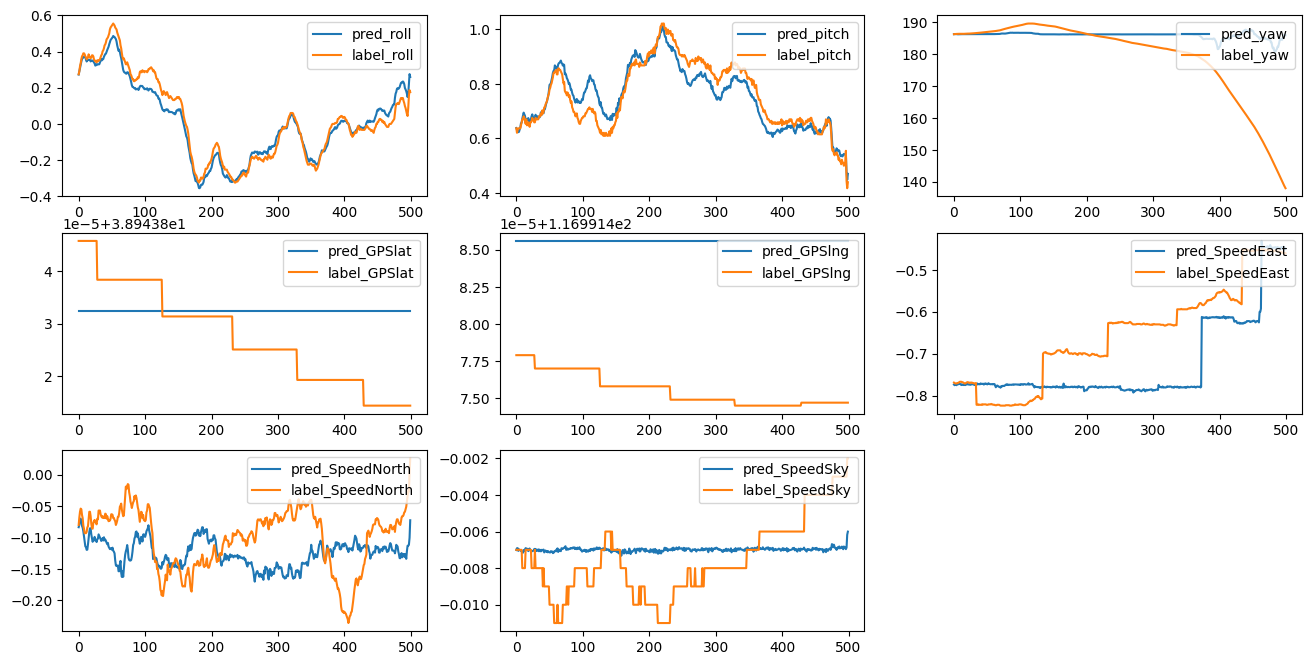

In [61]:
# 绘制姿态角曲线
fig = plt.figure(figsize=(16, 8))
index = 1
for label_name in ['roll', 'pitch', 'yaw',  'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']:
    plt.subplot(3, 3, index)
    plt.plot(range(multi_step_displacement_pred_result.shape[0]), multi_step_displacement_pred_result[f'pred_{label_name}'], label=f'pred_{label_name}')
    plt.plot(range(y_true_test.shape[0]), y_true_test[f'label_{label_name}'], label=f'label_{label_name}')
    plt.legend(loc='upper right')
    index += 1
plt.show()

### 自定义损失函数

In [142]:
df_cal_displacement = deepcopy(df2)
N = 9  # 历史窗口值 

GPSlat_mean = df_cal_displacement['GPSlat'].mean()
GPSlng_mean = df_cal_displacement['GPSlng'].mean()

In [143]:
GPSlat_mean

38.94387931223279

In [144]:
GPSlng_mean

116.99157917986511

In [145]:
df_cal_displacement['GPSlat'] = (df_cal_displacement['GPSlat'] - GPSlat_mean)*10000
df_cal_displacement['GPSlng'] = (df_cal_displacement['GPSlng'] - GPSlng_mean)*10000
df_cal_displacement.head(5)

,Ax,Ay,Az,Gx,Gy,Gz,roll,pitch,yaw,SpeedEast,...,height,GPSlat,GPSlng,GPSheight,GPSspeed,GPSheading,RTKlat,RTKlng,useless,useless3
0,0.103259,-0.064724,-9.807859,0.022537,-0.025295,0.044811,-0.033,0.6317,96.0864,0.001,...,12.141,-0.695122,-0.948799,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
1,0.078615,-0.041932,-9.807854,0.006565,0.001663,-0.026666,-0.033,0.6317,96.0864,0.001,...,12.141,-0.695122,-0.948799,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
2,0.103286,-0.041934,-9.783177,-0.010336,0.005162,-0.105716,-0.033,0.6317,96.0864,0.001,...,12.141,-0.695122,-0.948799,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
3,0.128002,0.003628,-9.807908,-0.021585,0.018490,-0.149164,-0.033,0.6317,96.0864,0.001,...,12.141,-0.695122,-0.948799,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0
4,0.127989,0.003614,-9.807908,-0.026712,0.025154,-0.137345,-0.033,0.6317,96.0809,0.001,...,12.141,-0.695122,-0.948799,9.26,0.014,192.085,38.943813,116.991488,0.0,0.0


In [150]:
# label和时序特征的构造
# label
df_cal_displacement['label_roll'] = df_cal_displacement['roll'].shift(-1)
df_cal_displacement['label_pitch'] = df_cal_displacement['pitch'].shift(-1)
df_cal_displacement['label_yaw'] = df_cal_displacement['yaw'].shift(-1)
df_cal_displacement['label_GPSlat'] = df_cal_displacement['GPSlat'].shift(-1)
df_cal_displacement['label_GPSlng'] = df_cal_displacement['GPSlng'].shift(-1)
df_cal_displacement['label_SpeedEast'] = df_cal_displacement['SpeedEast'].shift(-1)
df_cal_displacement['label_SpeedNorth'] = df_cal_displacement['SpeedNorth'].shift(-1)
df_cal_displacement['label_SpeedSky'] = df_cal_displacement['SpeedSky'].shift(-1)

# features
# fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw']
fea_names = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz']
for fea in fea_names:
    for n in range(1, N+1):
        df_cal_displacement[f'{fea}_last_{n}'] = df_cal_displacement[fea].shift(n)
df_cal_displacement = df_cal_displacement.dropna(how='any')

# xgboost初试
X = df_cal_displacement.iloc[:-1000].drop(['lat', 'lng', 'height', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                            'useless', 'useless3', 'label_roll', 'label_pitch','label_yaw', 'label_GPSlat',
                                            'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky',], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw', 'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']
X = X.loc[:, feature_list]
y = df_cal_displacement.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng',
                                       'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']]


# 定义加权的 MSE 损失函数
def weighted_mse(preds, dtrain):
    # 自定义权重
    roll_weight = 1.0
    pitch_weight = 1.0
    yaw_weight = 1.0
    gpslat_weight = 1.0
    gpslng_weight = 10.0
    speedeast_weight = 1.0
    speednorth_weight = 1.0
    speedsky_weight = 1.0
 
    # print(preds.shape)
   
    labels = dtrain.get_label().reshape(preds.shape)
    # 计算残差
    residuals = labels - preds
    
    # 加权残差
    weighted_residuals = residuals * np.array([
        roll_weight, pitch_weight, yaw_weight,
        gpslat_weight, gpslng_weight,
        speedeast_weight, speednorth_weight, speedsky_weight
    ])
    
    grad = -2 * weighted_residuals
    hess = [roll_weight, pitch_weight, yaw_weight, gpslat_weight, gpslng_weight, speedeast_weight,
            speednorth_weight, speedsky_weight] * grad.shape[0]
    hess = [2*x for x in hess]
    

    # # 计算梯度（loss 对 pred 的一阶导数）
    # grad = -2 * residuals * np.array([
    #     roll_weight, pitch_weight, yaw_weight,
    #     gpslat_weight, gpslng_weight,
    #     speedeast_weight, speednorth_weight, speedsky_weight
    # ])

    # # 计算 Hessian（loss 对 pred 的二阶导数）
    # hess = 2 * np.array([
    #     roll_weight, pitch_weight, yaw_weight,
    #     gpslat_weight, gpslng_weight,
    #     speedeast_weight, speednorth_weight, speedsky_weight
    # ])

    return grad.flatten(), hess


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# 将数据转换为 DMatrix 格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

# 训练模型，使用自定义损失函数
weighted_model = xgb.train(
    params={'objective': 'reg:squarederror'},
    dtrain=dtrain,
    num_boost_round=100,
    obj=weighted_mse,
    verbose_eval=1)

# 进行预测
y_pred = weighted_model.predict(dtest)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
k = pd.concat([X_test.reset_index(drop=True), y_test.reset_index(drop=True), predicted_df.reset_index(drop=True)], axis=1)

Mean Squared Error: 0.013234110750496401


In [151]:
X_true_test = df_cal_displacement.iloc[-1000:-500].drop(['lat', 'lng', 'height', 'GPSheight', 'GPSheading', 'GPSspeed', 'RTKlat', 'RTKlng',
                                            'useless', 'useless3', 'label_roll', 'label_pitch', 'label_yaw',  'label_GPSlat',
                                            'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky',], axis=1)

# 调整列顺序
feature_list = ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
                'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
                'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
                'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
                'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
                'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
                'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9',
                'roll', 'pitch', 'yaw', 'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']
X_true_test = X_true_test.loc[:, feature_list].reset_index(drop=True)
y_true_test = df_cal_displacement.iloc[-1000:-500][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng',
                                       'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']].reset_index(drop=True)

In [152]:
multi_step_displacement_pred_result = None  # 测试集结果
multi_step_displacement_pred_sample = None  # 临时变量，保存单次预估结果
feature_list_part = [
    'Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz',
    'Ax_last_1', 'Ax_last_2', 'Ax_last_3', 'Ax_last_4', 'Ax_last_5', 'Ax_last_6', 'Ax_last_7', 'Ax_last_8', 'Ax_last_9',
    'Ay_last_1', 'Ay_last_2', 'Ay_last_3', 'Ay_last_4', 'Ay_last_5', 'Ay_last_6', 'Ay_last_7', 'Ay_last_8', 'Ay_last_9',
    'Az_last_1', 'Az_last_2', 'Az_last_3', 'Az_last_4', 'Az_last_5', 'Az_last_6', 'Az_last_7', 'Az_last_8', 'Az_last_9',
    'Gx_last_1', 'Gx_last_2', 'Gx_last_3', 'Gx_last_4', 'Gx_last_5', 'Gx_last_6', 'Gx_last_7', 'Gx_last_8', 'Gx_last_9',
    'Gy_last_1', 'Gy_last_2', 'Gy_last_3', 'Gy_last_4', 'Gy_last_5', 'Gy_last_6', 'Gy_last_7', 'Gy_last_8', 'Gy_last_9',
    'Gz_last_1', 'Gz_last_2', 'Gz_last_3', 'Gz_last_4', 'Gz_last_5', 'Gz_last_6', 'Gz_last_7', 'Gz_last_8', 'Gz_last_9']
# 循环遍历X_true_test，模型的预估值作为下一时刻模型的输入roll, pitch, yaw
for index in range(X_true_test.shape[0]):
    if index == 0:
        X_true_test_sample = X_true_test.iloc[index:index+1]
        X_true_test_sample = X_true_test_sample.loc[:, feature_list]
        X_true_test_sample = xgb.DMatrix(X_true_test_sample)
        y_pred_sample = weighted_model.predict(X_true_test_sample)
        multi_step_displacement_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
        multi_step_displacement_pred_result = multi_step_displacement_pred_sample
    else:
        X_true_test_sample = X_true_test.loc[index:index, feature_list_part]
        X_true_test_sample = pd.concat([X_true_test_sample.reset_index(drop=True),
                                        multi_step_displacement_pred_sample.reset_index(drop=True)], axis=1)
        X_true_test_sample.columns = feature_list
        X_true_test_sample = xgb.DMatrix(X_true_test_sample)
        y_pred_sample = weighted_model.predict(X_true_test_sample)
        multi_step_displacement_pred_sample = pd.DataFrame(y_pred_sample, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
        multi_step_displacement_pred_result = pd.concat([multi_step_displacement_pred_result, multi_step_displacement_pred_sample], axis=0)
        
# multi_step_displacement_pred_result.head()

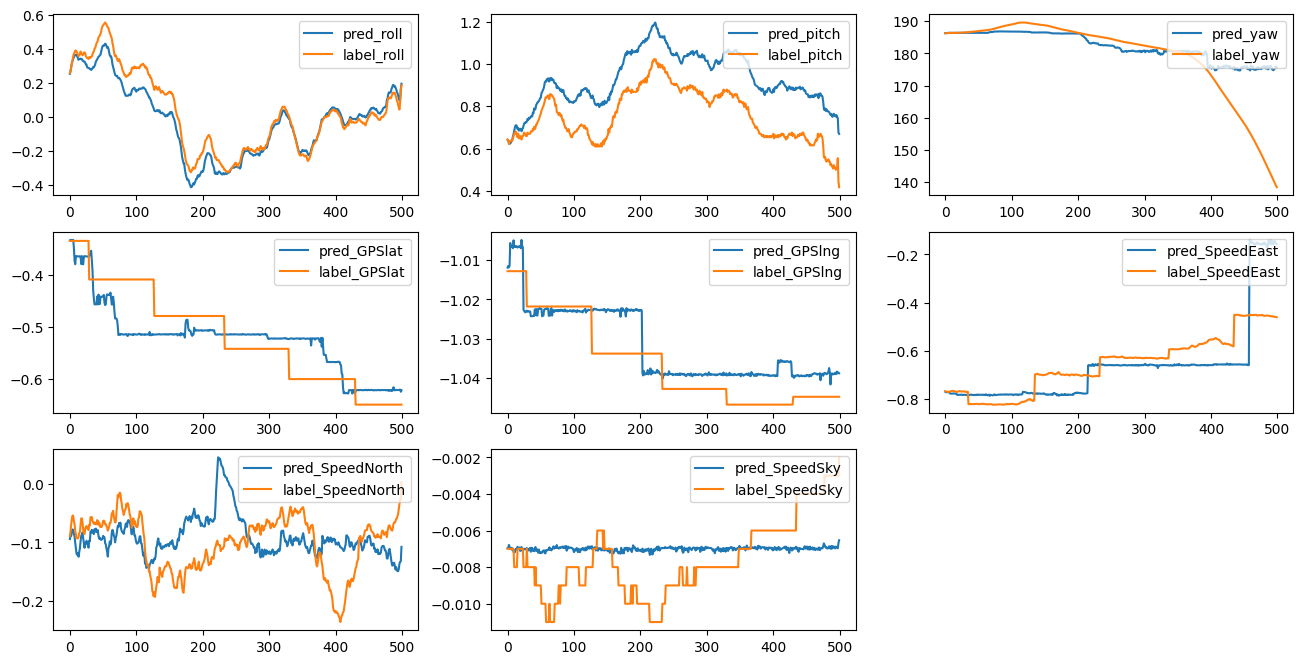

In [153]:
# 绘制姿态角曲线
fig = plt.figure(figsize=(16, 8))
index = 1
for label_name in ['roll', 'pitch', 'yaw',  'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']:
    plt.subplot(3, 3, index)
    plt.plot(range(multi_step_displacement_pred_result.shape[0]), multi_step_displacement_pred_result[f'pred_{label_name}'], label=f'pred_{label_name}')
    plt.plot(range(y_true_test.shape[0]), y_true_test[f'label_{label_name}'], label=f'label_{label_name}')
    plt.legend(loc='upper right')
    index += 1
plt.show()

## LSTM

In [46]:
# 使用深度学习模型进行建模

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设 df_cal_attitude_multi_step 已经构造完毕
df_cal_displacement_lstm = deepcopy(df2)
# df_cal_attitude_lstm['label_roll'] = df_cal_attitude_lstm['roll'].shift(-1)
# df_cal_attitude_lstm['label_yaw'] = df_cal_attitude_lstm['yaw'].shift(-1)
# df_cal_attitude_lstm['label_pitch'] = df_cal_attitude_lstm['pitch'].shift(-1)

df_cal_displacement_lstm['label_roll'] = df_cal_displacement_lstm['roll'].shift(-1)
df_cal_displacement_lstm['label_pitch'] = df_cal_displacement_lstm['pitch'].shift(-1)
df_cal_displacement_lstm['label_yaw'] = df_cal_displacement_lstm['yaw'].shift(-1)
df_cal_displacement_lstm['label_GPSlat'] = df_cal_displacement_lstm['GPSlat'].shift(-1)
df_cal_displacement_lstm['label_GPSlng'] = df_cal_displacement_lstm['GPSlng'].shift(-1)
df_cal_displacement_lstm['label_SpeedEast'] = df_cal_displacement_lstm['SpeedEast'].shift(-1)
df_cal_displacement_lstm['label_SpeedNorth'] = df_cal_displacement_lstm['SpeedNorth'].shift(-1)
df_cal_displacement_lstm['label_SpeedSky'] = df_cal_displacement_lstm['SpeedSky'].shift(-1)
df_cal_displacement_lstm = df_cal_displacement_lstm.dropna(how='any')

# 准备特征和标签
X = df_cal_displacement_lstm.iloc[:-1000].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw', 
                                                  'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']]
y = df_cal_displacement_lstm.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']]

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

# 将数据转化为序列形式
N = 9  # 历史窗口值
X_seq = []
y_seq = []

for i in range(N, len(X_tensor)):
    X_seq.append(X_tensor[i-N:i])
    y_seq.append(y_tensor[i])

X_seq = torch.stack(X_seq)
y_seq = torch.stack(y_seq)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# 初始化模型
input_size = X_tensor.shape[1]
hidden_size = 256
output_size = 8  # roll, pitch, yaw

model = LSTMModel(input_size, hidden_size, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 反标准化
y_pred = scaler_y.inverse_transform(y_pred.numpy())
y_test = scaler_y.inverse_transform(y_test.numpy())

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 显示预测结果
predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
print(predicted_df.head())

f:\Anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [10/200], Loss: 0.5700
Epoch [20/200], Loss: 0.2307
Epoch [30/200], Loss: 0.1375
Epoch [40/200], Loss: 0.0750
Epoch [50/200], Loss: 0.0467
Epoch [60/200], Loss: 0.0326
Epoch [70/200], Loss: 0.0258
Epoch [80/200], Loss: 0.0200
Epoch [90/200], Loss: 0.0157
Epoch [100/200], Loss: 0.0125
Epoch [110/200], Loss: 0.0102
Epoch [120/200], Loss: 0.0086
Epoch [130/200], Loss: 0.0075
Epoch [140/200], Loss: 0.0068
Epoch [150/200], Loss: 0.0064
Epoch [160/200], Loss: 0.0060
Epoch [170/200], Loss: 0.0057
Epoch [180/200], Loss: 0.0054
Epoch [190/200], Loss: 0.0052
Epoch [200/200], Loss: 0.0051
Mean Squared Error: 8.979016304016113
   pred_roll  pred_pitch    pred_yaw  pred_GPSlat  pred_GPSlng  \
0  -0.456099    0.271585   96.985443    38.943802   116.991585   
1   0.189152    0.465760    5.460237    38.943851   116.991676   
2   0.528012    0.630760   21.860834    38.943794   116.991669   
3  -0.285864    0.365913  184.154373    38.943935   116.991486   
4  -0.157931    0.585415  183.916885    3

In [48]:
# 对真实Test集进行连续预测，并得到连续变化的姿态角
X_true_test = df_cal_displacement_lstm.iloc[-1000:-500].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw', 
                                                    'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']]
y_true_test = df_cal_displacement_lstm.iloc[-1000:-500][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng',
                                                    'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']]

lstm_test_result = None

X_true_test_scaled = scaler_X.fit_transform(X_true_test)
# y_scaled = scaler_y.fit_transform(y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_true_test_scaled)
# y_tensor = torch.FloatTensor(y_scaled)

# 将数据转化为序列形式
N = 9  # 历史窗口值

# 进行预测
model.eval()
with torch.no_grad():
    for i in range(N, len(X_tensor)):
        X_seq = []
        X_seq.append(X_tensor[i-N:i])
        X_seq = torch.stack(X_seq)
        y_pred = model(X_seq)
        X_tensor[i, -8:] = y_pred.squeeze()
        y_pred = scaler_y.inverse_transform(y_pred.numpy())
        predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng',
                                                      'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
        lstm_test_result = pd.concat([lstm_test_result, predicted_df], axis=0)

lstm_test_result.head(5)

,pred_roll,pred_pitch,pred_yaw,pred_GPSlat,pred_GPSlng,pred_SpeedEast,pred_SpeedNorth,pred_SpeedSky
0,0.781716,0.357674,224.721069,38.943985,116.991714,-0.174534,0.207833,-0.001630
0,0.798681,0.387846,228.186661,38.943985,116.991714,-0.152703,0.204270,-0.001810
0,0.806387,0.421445,232.254990,38.943981,116.991714,-0.136797,0.189342,-0.002013
0,0.788503,0.449239,235.233109,38.943981,116.991707,-0.127431,0.165469,-0.001947
0,0.803112,0.454381,242.846786,38.943977,116.991707,-0.094627,0.144264,-0.001840


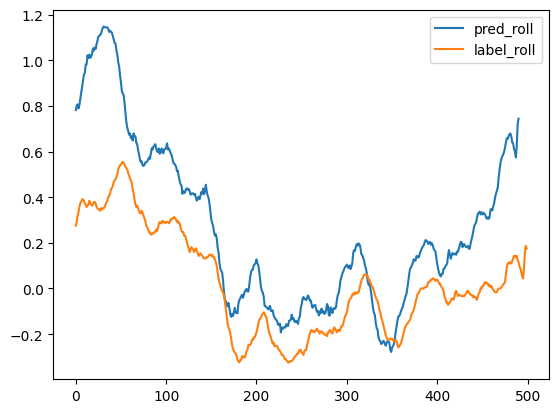

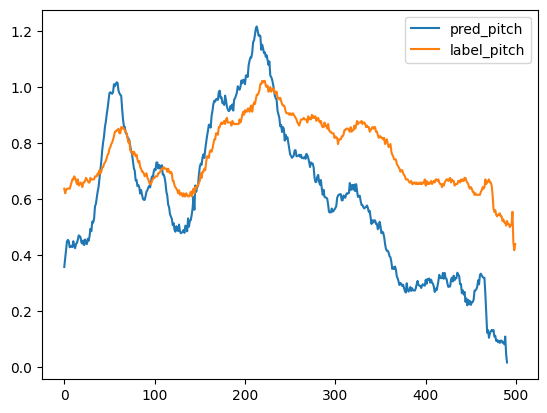

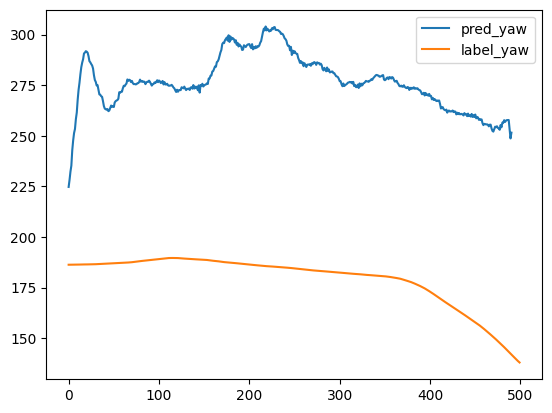

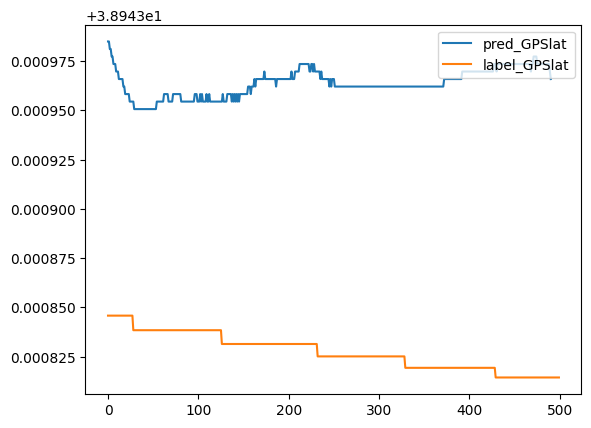

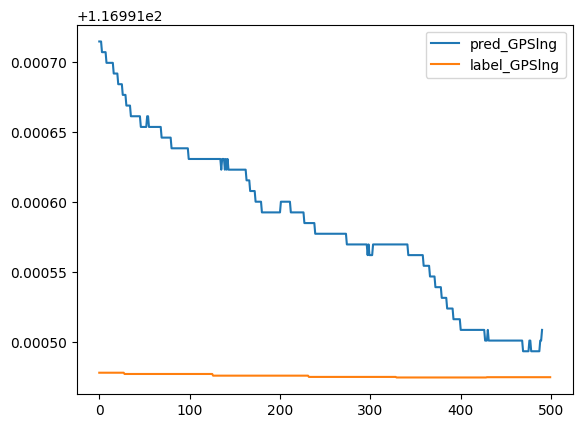

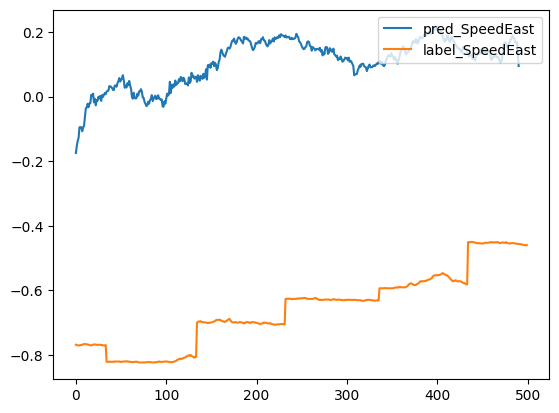

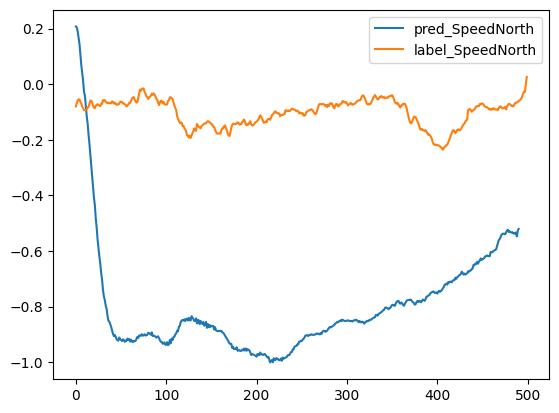

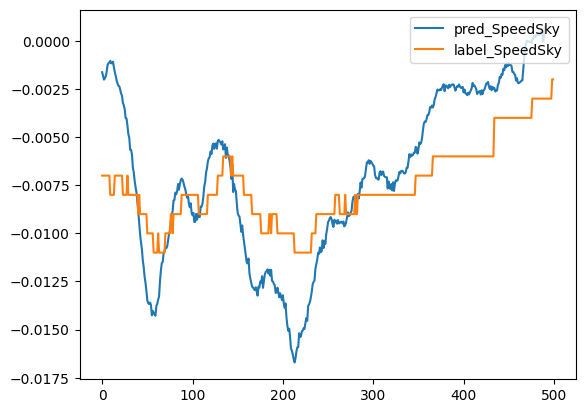

In [52]:
# 绘制姿态角曲线
for  label_name in ['roll', 'pitch', 'yaw',  'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']:
    plt.plot(range(lstm_test_result.shape[0]), lstm_test_result[f'pred_{label_name}'], label=f'pred_{label_name}')
    plt.plot(range(y_true_test.shape[0]), y_true_test[f'label_{label_name}'], label=f'label_{label_name}')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
### label

In [ ]:
# 使用深度学习模型进行建模

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 假设 df_cal_attitude_multi_step 已经构造完毕
df_cal_displacement_lstm = deepcopy(df2)
# df_cal_attitude_lstm['label_roll'] = df_cal_attitude_lstm['roll'].shift(-1)
# df_cal_attitude_lstm['label_yaw'] = df_cal_attitude_lstm['yaw'].shift(-1)
# df_cal_attitude_lstm['label_pitch'] = df_cal_attitude_lstm['pitch'].shift(-1)

df_cal_displacement_lstm['label_roll'] = df_cal_displacement_lstm['roll'].shift(-1)
df_cal_displacement_lstm['label_pitch'] = df_cal_displacement_lstm['pitch'].shift(-1)
df_cal_displacement_lstm['label_yaw'] = df_cal_displacement_lstm['yaw'].shift(-1)
df_cal_displacement_lstm['label_GPSlat'] = df_cal_displacement_lstm['GPSlat'].shift(-1)
df_cal_displacement_lstm['label_GPSlng'] = df_cal_displacement_lstm['GPSlng'].shift(-1)
df_cal_displacement_lstm['label_SpeedEast'] = df_cal_displacement_lstm['SpeedEast'].shift(-1)
df_cal_displacement_lstm['label_SpeedNorth'] = df_cal_displacement_lstm['SpeedNorth'].shift(-1)
df_cal_displacement_lstm['label_SpeedSky'] = df_cal_displacement_lstm['SpeedSky'].shift(-1)
df_cal_displacement_lstm = df_cal_displacement_lstm.dropna(how='any')

# 准备特征和标签
X = df_cal_displacement_lstm.iloc[:-1000].loc[:, ['Ax', 'Ay', 'Az', 'Gx', 'Gy', 'Gz', 'roll', 'pitch', 'yaw', 
                                                  'GPSlat', 'GPSlng', 'SpeedEast', 'SpeedNorth', 'SpeedSky']]
y = df_cal_displacement_lstm.iloc[:-1000][['label_roll', 'label_pitch', 'label_yaw', 'label_GPSlat', 'label_GPSlng', 'label_SpeedEast', 'label_SpeedNorth', 'label_SpeedSky']]

# 标准化数据
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 转换为PyTorch张量
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y_scaled)

# 将数据转化为序列形式
N = 9  # 历史窗口值
X_seq = []
y_seq = []

for i in range(N, len(X_tensor)):
    X_seq.append(X_tensor[i-N:i])
    y_seq.append(y_tensor[i])

X_seq = torch.stack(X_seq)
y_seq = torch.stack(y_seq)

# 拆分数据集
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, (h_n, c_n) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

# 初始化模型
input_size = X_tensor.shape[1]
hidden_size = 256
output_size = 8  # roll, pitch, yaw

model = LSTMModel(input_size, hidden_size, output_size)

# 设置损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# 进行预测
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

# 反标准化
y_pred = scaler_y.inverse_transform(y_pred.numpy())
y_test = scaler_y.inverse_transform(y_test.numpy())

# 计算均方误差
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# 显示预测结果
predicted_df = pd.DataFrame(y_pred, columns=['pred_roll', 'pred_pitch', 'pred_yaw', 'pred_GPSlat', 'pred_GPSlng', 'pred_SpeedEast', 'pred_SpeedNorth', 'pred_SpeedSky'])
print(predicted_df.head())